# A machine learning approach for the classification of cardiac arrhythmia
The aim of this project is to determine the type of arrhythmia from the ECG recordings.

Eleonora Detić, 1191241491

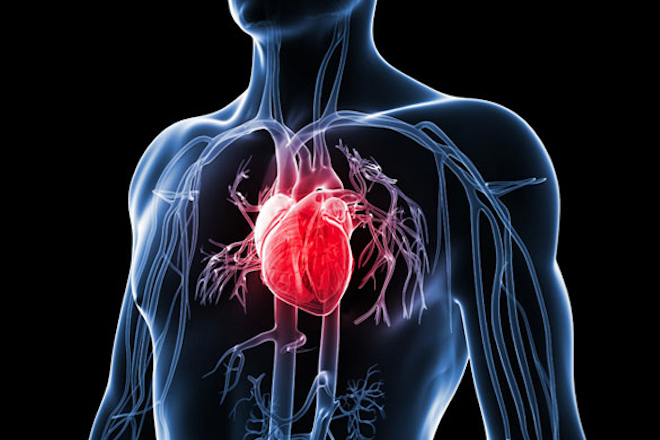

In [501]:
from IPython.display import Image
Image('/Users/eleonoradetic/UZOP/heart.jpg')

---------

### Data collection

Type of research:

- by purpose: **applied** - application in medicine for the early detection of cardiac arrhythmia

- by depth: **correlational** - we study how independent variable("diagnosis") is affected by several distinct dependent variables("age", "sex"..)

- by data type: **quantitative** - we have mathematical, measurable and comparable data

- by variable manipulation: **observational** - researchers observe patients

- by conclusion: **inductive** - we want to generalize things based on sample of pacients

- by time: **synchronous** - we assume that all data are collected at the same time

- by source of information: **secondary** - the researchers read informations about patients from medical documents

- according to the method of data collection: **mixed** - a combination of data known about patients through medical records and ECG data measured under controlled conditions

Data collection method - **documentary** - **limited access**: the main source of data are the patient's medical records.

Data were collected **according to the rules of research ethics** - the names and id numbers of the patients were removed from the database for the privacy purpose.


---------
### Data survey

In [425]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from pca import pca
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import sklearn.model_selection as model_selection
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [426]:
df = pd.read_csv('data_arrhythmia.csv', delimiter=';')
df.dataframeName = 'data_arrhythmia.csv'
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [427]:
print(df.columns.values)

['age' 'sex' 'height' 'weight' 'qrs_duration' 'p-r_interval'
 'q-t_interval' 't_interval' 'p_interval' 'qrs' 'T' 'P' 'QRST' 'J'
 'heart_rate' 'q_wave' 'r_wave' 's_wave' "R'_wave" "S'_wave" 'AA' 'AB'
 'AC' 'AD' 'AE' 'AF' 'AG' 'AH' 'AI' 'AJ' 'AK' 'AL' 'AM' 'AN' 'AO' 'AP'
 'AR' 'AS' 'AT' 'AU' 'AV' 'AY' 'AZ' "AB'" 'BB' 'BC' 'BD' 'BE' 'BF' 'BG'
 'BH' 'BI' 'BJ' 'BK' 'BL' 'BM' 'BN' 'BO' 'BP' 'BR' 'BS' 'BT' 'BU' 'BV'
 'BY' 'BZ' 'CA' 'CB' 'CC' 'CD' 'CE' 'Cf' 'CG' 'CH' 'CI' 'CJ' 'CK' 'CL'
 'CM' 'CN' 'CO' 'CP' 'CR' 'CS' 'CT' 'CU' 'CV' 'CY' 'CZ' 'DA' 'DB' 'DC'
 'DD' 'DE' 'DF' 'DG' 'DH' 'DI' 'DJ' 'DK' 'DL' 'DM' 'DN' 'DO' 'DP' 'DR'
 'DS' 'DT' 'DU' 'DV' 'DY' 'DZ' 'EA' 'EB' 'EC' 'ED' 'EF' 'EG' 'EH' 'EI'
 'EJ' 'EK' 'EL' 'EM' 'EN' 'EO' 'EP' 'ER' 'ES' 'ET' 'EU' 'EV' 'EY' 'EZ'
 'FA' 'FB' 'FC' 'FD' 'FE' 'FF' 'FG' 'FH' 'FI' 'FJ' 'FK' 'FL' 'FM' 'FN'
 'FO' 'FP' 'FR' 'FS' 'FT' 'FU' 'FV' 'FY' 'FZ' 'GA' 'GB' 'GC' 'GD' 'GE'
 'GF' 'GG' 'GH' 'GI' 'GJ' 'GK' 'GL' 'GM' 'GN' 'GO' 'GP' 'GR' 'GS' 'GT'
 'GU' 'GV' 'GY' 'GZ

In [428]:
df.describe()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.425000,6.600000,-2.100000,0.000000,0.0,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,0.000000,8.800000,-1.100000,0.000000,0.0,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,11.200000,0.000000,0.000000,0.0,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,0.000000,23.600000,0.000000,0.800000,0.0,2.400000,6.000000,88.800000,115.900000,16.000000


In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to diagnosis
dtypes: float64(116), int64(159), object(5)
memory usage: 988.9+ KB


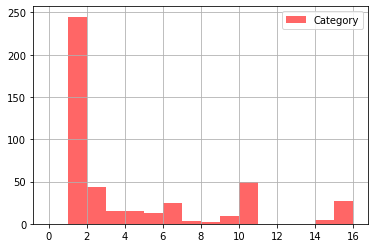

In [430]:
plt.hist(df['diagnosis'], bins=16, range=(0,16), label='Category', color='red', alpha=0.6)
plt.legend(loc='best')
plt.grid()
plt.show()

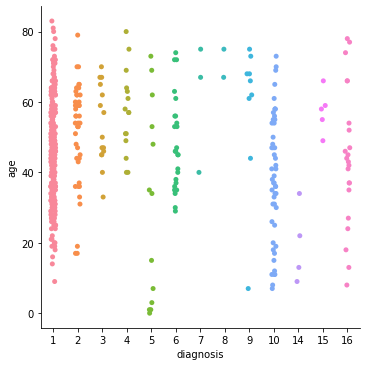

In [431]:
sns.catplot(x="diagnosis", y="age", data=df)   

In our data set, we have 452 patients and 279 features for each patient. Some variables are categorical(sex) and some continuous(age). <br> We do not have monotone data, but we have constants data.
Last column is interpreted as a number of heart arrhythmia claster. According to documentation, missing attribute values are distinguished with '?' so the first step is to replace them with "NaN". After that, we will remove the variables that are constant because they tell us nothing about pacients.

In [432]:
df[df == '?'].count().nlargest(10)

J               376
P                22
T                 8
QRST              1
heart_rate        1
age               0
sex               0
height            0
weight            0
qrs_duration      0
dtype: int64

<AxesSubplot:title={'center':'Frequency of NaN values'}>

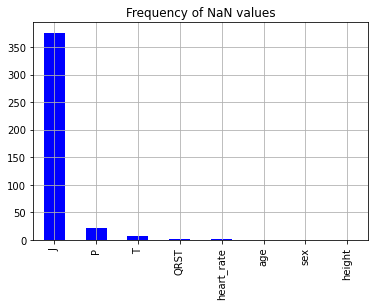

In [433]:
df = df.replace('?', np.NaN)
df.isna().sum().nlargest(8).plot(kind="bar", title="Frequency of NaN values", color='blue', grid='bool')

As we can see, in column 'J' we have a lof of missing values, more than 80%, so we will drop that column.

In [434]:
df.drop(['J'], axis=1, inplace=True)

As for the other columns, since these variables are continuous, the first idea could be to hope for a normal distribution and then try to preserve the variability of the data by randomly simulate the missing values. <br> For this purpose, we perform well know **Kolmogorov–Smirnov** test.

In [435]:
print(stats.kstest(df[df['P'].notnull()]['P'].astype(int), 'norm'))
print(stats.kstest(df[df['T'].notnull()]['T'].astype(int), 'norm'))
print(stats.kstest(df[df['QRST'].notnull()]['QRST'].astype(int), 'norm'))
print(stats.kstest(df[df['heart_rate'].notnull()]['heart_rate'].astype(int), 'norm'))

KstestResult(statistic=0.9255811086972653, pvalue=0.0)
KstestResult(statistic=0.847749201067469, pvalue=0.0)
KstestResult(statistic=0.8168319201501881, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


This assumption was obviously too ambitious. For all columns, the p value turned out to be very small and the test statistics very large. <br> So our conclusion is that at each standard level of significance, we reject the null hypothesis, that is, that our data **do not follow** a normal distribution. <br>
The next idea is standard. We will replace the missing values with the mean of each column.

In [436]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean') # we could also put here '?' as an argument instead of np.nan, but we replace them above
idf = pd.DataFrame(imp.fit_transform(df))
idf.columns = df.columns
idf.index = df.index
df = idf
df.isna().sum().nlargest(10)

age             0
sex             0
height          0
weight          0
qrs_duration    0
p-r_interval    0
q-t_interval    0
t_interval      0
p_interval      0
qrs             0
dtype: int64

Finally, there are no more missing values in our data. <br>
As said before, very important step is to drop constant variables.

<AxesSubplot:title={'center':'Number of unique values per column'}>

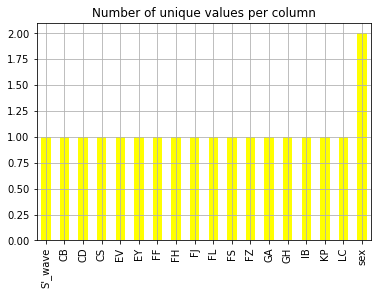

In [437]:
df.nunique().nsmallest(18).plot(kind="bar", title="Number of unique values per column", color='yellow', grid='bool')

In [438]:
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

Box plot for age


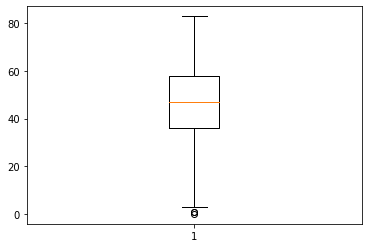

Box plot for height


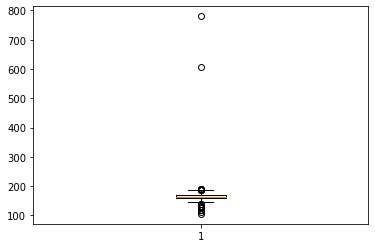

Box plot for weight


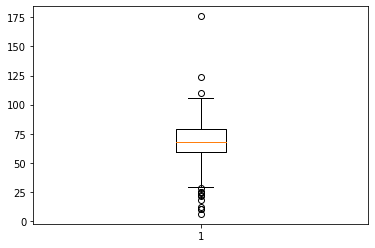

Box plot for qrs_duration


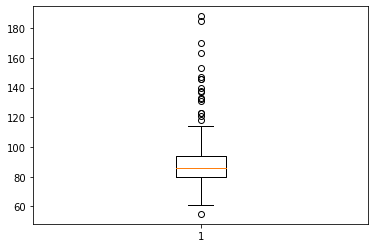

Box plot for p-r_interval


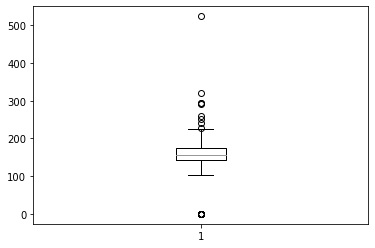

Box plot for q-t_interval


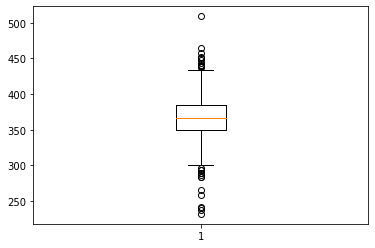

Box plot for t_interval


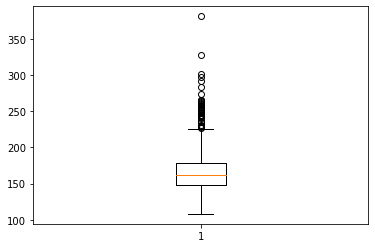

Box plot for p_interval


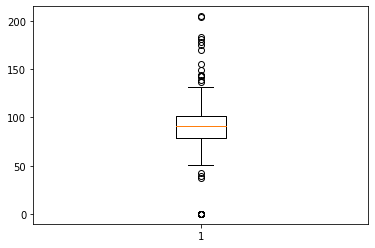

Box plot for qrs


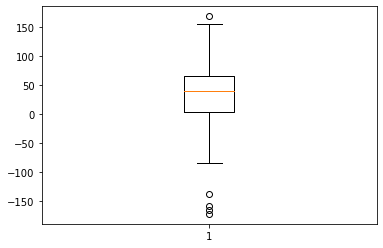

In [439]:
continuos_col = ['age', 'height','weight','qrs_duration', 'p-r_interval','q-t_interval','t_interval','p_interval','qrs']
i = 0 
for c in continuos_col:
        #if(df[c].max()  > df[c].mean() + 3 * df[c].std()):
                i= i+1 
                print('Box plot for', c)
                plt.boxplot(df[c])
                plt.show()

Obviously, there are definitely outliers in the ‘height’ column. It is impossible for a patient to be taller than 250 cm.

In [440]:
df['height'].nlargest(5)

141    780.0
316    608.0
0      190.0
4      190.0
448    190.0
Name: height, dtype: float64

In [441]:
df = df[df.height < 500]

In [442]:
df #450 x 262

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KV,KY,KZ,LA,LB,LD,LE,LF,LG,diagnosis
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,-0.3,0.0,9.0,-0.9,0.0,0.9,2.9,23.3,49.4,8.0
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,-0.5,0.0,8.5,0.0,0.0,0.2,2.1,20.4,38.8,6.0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.9,0.0,9.5,-2.4,0.0,0.3,3.4,12.3,49.0,10.0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.1,0.0,12.2,-2.2,0.0,0.4,2.6,34.6,61.6,1.0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,-0.4,0.0,13.1,-3.6,0.0,-0.1,3.9,25.4,62.8,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53.0,1.0,160.0,70.0,80.0,199.0,382.0,154.0,117.0,-37.0,...,0.0,0.0,4.3,-5.0,0.0,0.7,0.6,-4.4,-0.5,1.0
448,37.0,0.0,190.0,85.0,100.0,137.0,361.0,201.0,73.0,86.0,...,-0.5,0.0,15.6,-1.6,0.0,0.4,2.4,38.0,62.4,10.0
449,36.0,0.0,166.0,68.0,108.0,176.0,365.0,194.0,116.0,-85.0,...,1.2,0.0,16.3,-28.6,0.0,1.5,1.0,-44.2,-33.2,2.0
450,32.0,1.0,155.0,55.0,93.0,106.0,386.0,218.0,63.0,54.0,...,0.2,-0.4,12.0,-0.7,0.0,0.5,2.4,25.0,46.6,1.0


Last but not least, detecting parse data. 

In [443]:
df.astype(bool).sum(axis=0).nsmallest(80)

CI    0
AB    1
AL    1
AP    1
BC    1
     ..
AT    7
DF    7
AN    8
BF    8
CE    8
Length: 80, dtype: int64

As we can see, by removing that outlier, column "CI" became constant, so we will remove it too. 

In [444]:
df.drop(['CI'], axis=1, inplace=True)

There are many ways to examine correlation, for example - heat map, but we will focus on finding the maximum and minimum elements of a symmetric correlation matrix.

In [445]:
corr_matrix= df.corr()
columns = list(df.columns)

for c in columns:
    if(corr_matrix[c].nlargest(2)[1] > 0.99):
        print("Positive correlation: ", c) 
        print(corr_matrix[c].nlargest(2))
    if(corr_matrix[c].nsmallest(2)[0] < -0.9999):
        print("Negative correlation: ", c) 
        print(corr_matrix[c].nsmallest(1))

Negative correlation:  AL
GS   -1.0
Name: AL, dtype: float64
Negative correlation:  BM
HO   -1.0
Name: BM, dtype: float64
Negative correlation:  CN
IL   -0.999992
Name: CN, dtype: float64
Positive correlation:  FR
FR    1.000000
LB    0.997769
Name: FR, dtype: float64
Negative correlation:  GS
AL   -1.0
Name: GS, dtype: float64
Negative correlation:  HO
BM   -1.0
Name: HO, dtype: float64
Negative correlation:  IL
CN   -0.999992
Name: IL, dtype: float64
Positive correlation:  LB
LB    1.000000
FR    0.997769
Name: LB, dtype: float64


Between the two variables that are strongly correlated, we will keep only one of them.

In [446]:
df.drop(['GS'], axis=1, inplace=True)
df.drop(['HO'], axis=1, inplace=True)
df.drop(['IL'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)

In [447]:
df.astype(bool).sum(axis=0).nsmallest(88)

AB     1
AL     1
AP     1
BC     1
BE     1
      ..
IA    11
AO    13
CM    13
IK    13
EP    15
Length: 88, dtype: int64

Unfortunately, a big problem arises here. We have a lot of parse data. It is generally known that the algorithms we want to develop will behave badly with such data. We will focus to those that have up to 15 different values from zero and turn them into dummy variables.

In [448]:
df

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KU,KV,KY,KZ,LA,LD,LE,LF,LG,diagnosis
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,62.9,-0.3,0.0,9.0,-0.9,0.9,2.9,23.3,49.4,8.0
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,43.4,-0.5,0.0,8.5,0.0,0.2,2.1,20.4,38.8,6.0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,48.2,0.9,0.0,9.5,-2.4,0.3,3.4,12.3,49.0,10.0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,68.0,0.1,0.0,12.2,-2.2,0.4,2.6,34.6,61.6,1.0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,48.9,-0.4,0.0,13.1,-3.6,-0.1,3.9,25.4,62.8,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53.0,1.0,160.0,70.0,80.0,199.0,382.0,154.0,117.0,-37.0,...,-0.6,0.0,0.0,4.3,-5.0,0.7,0.6,-4.4,-0.5,1.0
448,37.0,0.0,190.0,85.0,100.0,137.0,361.0,201.0,73.0,86.0,...,82.5,-0.5,0.0,15.6,-1.6,0.4,2.4,38.0,62.4,10.0
449,36.0,0.0,166.0,68.0,108.0,176.0,365.0,194.0,116.0,-85.0,...,-63.6,1.2,0.0,16.3,-28.6,1.5,1.0,-44.2,-33.2,2.0
450,32.0,1.0,155.0,55.0,93.0,106.0,386.0,218.0,63.0,54.0,...,61.0,0.2,-0.4,12.0,-0.7,0.5,2.4,25.0,46.6,1.0


In [449]:
categorical_cols = list(df.astype(bool).sum(axis=0).nsmallest(87).index) #91 - this number can be arbitrary ofcourse, but we decide there is max. 13 dummy variables for one variable
df = pd.get_dummies(df, columns=categorical_cols)

In [450]:
df

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,IK_0.0,IK_0.4,IK_0.5,IK_0.7,IK_0.8,IK_1.0,IK_1.3,IK_1.6,IK_1.8,IK_3.9
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,1,0,0,0,0,0,0,0,0,0
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,1,0,0,0,0,0,0,0,0,0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,1,0,0,0,0,0,0,0,0,0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,1,0,0,0,0,0,0,0,0,0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53.0,1.0,160.0,70.0,80.0,199.0,382.0,154.0,117.0,-37.0,...,1,0,0,0,0,0,0,0,0,0
448,37.0,0.0,190.0,85.0,100.0,137.0,361.0,201.0,73.0,86.0,...,1,0,0,0,0,0,0,0,0,0
449,36.0,0.0,166.0,68.0,108.0,176.0,365.0,194.0,116.0,-85.0,...,1,0,0,0,0,0,0,0,0,0
450,32.0,1.0,155.0,55.0,93.0,106.0,386.0,218.0,63.0,54.0,...,1,0,0,0,0,0,0,0,0,0


It seems natural that the patient's age and weight could have the greatest impact on the category of cardiac arrhythmia, so we perform Feature Engineering.

In [451]:
df['age'] = pd.cut(df['age'], 8)
le = LabelEncoder()
le.fit(df.loc[:,'age'])
le.transform(df.loc[:,'age'])

df.loc[:,'age'] = le.transform(df.loc[:,'age'])

In [452]:
df['weight'] = pd.cut(df['weight'], 5)
le = LabelEncoder()
le.fit(df.loc[:,'weight'])
le.transform(df.loc[:,'weight'])

df.loc[:,'weight'] = le.transform(df.loc[:,'weight'])

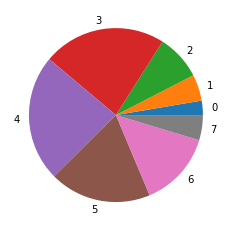

In [453]:
count_per_title = df.groupby('age').count().loc[:,'sex'].values
title_name = df.groupby('age').count().index.values
percent = (count_per_title/len(df))*100

plt.pie(percent, labels=title_name)
plt.show()

We notice that we have a relatively good number of all age groups.

Once we have prepared the data in the form we think is best to work with, next step is to reduce dimension by using PCA.

---------
### Principal Component Analysis

Before using PCA, the first step is to scale the features in our data. 

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [414] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [118] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[118]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


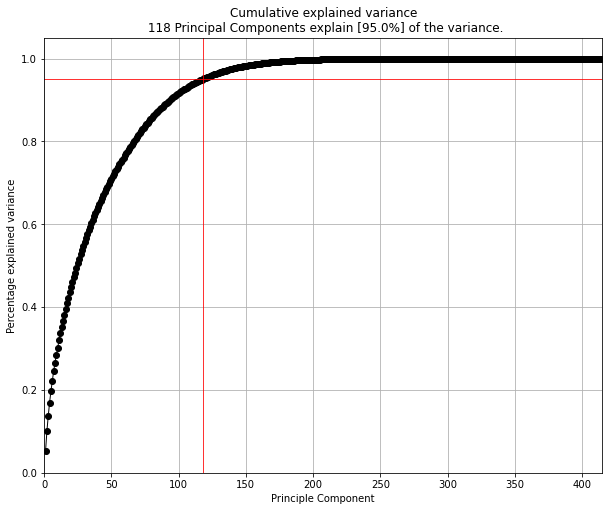

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 118 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [454]:
X = df.iloc[:, df.columns != 'diagnosis'].values
y = df.iloc[:, df.columns == 'diagnosis'].values

X = StandardScaler().fit_transform(X)

model = pca()
out = model.fit_transform(X)
model.plot()

As we can see, 120 Principal Components explain 95% of the variance and 150 Principal Components explain about 99% of the variance. 

In [455]:
model.compute_topfeat()

,PC,feature,loading,type
0,PC1,92,-0.181570,best
1,PC2,168,0.177916,best
2,PC3,143,-0.169263,best
3,PC4,5,0.166063,best
4,PC5,223,-0.187184,best
...,...,...,...,...
570,PC313,400,-0.188087,weak
571,PC407,409,-0.397570,weak
572,PC413,410,0.587819,weak
573,PC414,411,0.604788,weak


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'118 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (5.23% expl.var)', ylabel='PC2 (4.77% expl.var)'>)

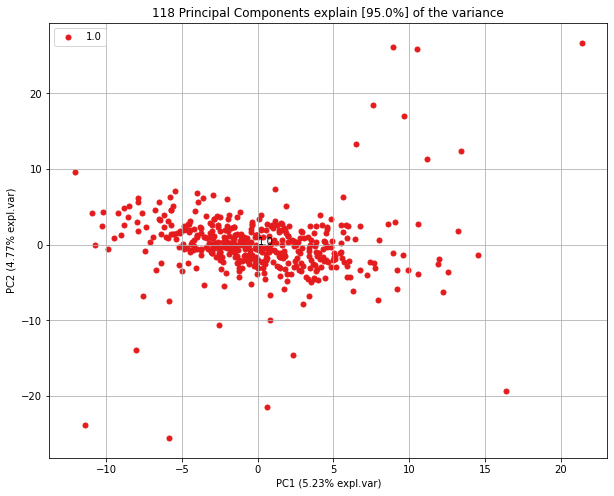

In [456]:
model.scatter()

But since we have many features, it is easy to notice that a small percentage of variability is explained only with the first two PCA components. <br>
Also, this method has a convenient application for outliers detection. Let's illustrate that!

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'118 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (5.23% expl.var)', ylabel='PC2 (4.77% expl.var)'>)

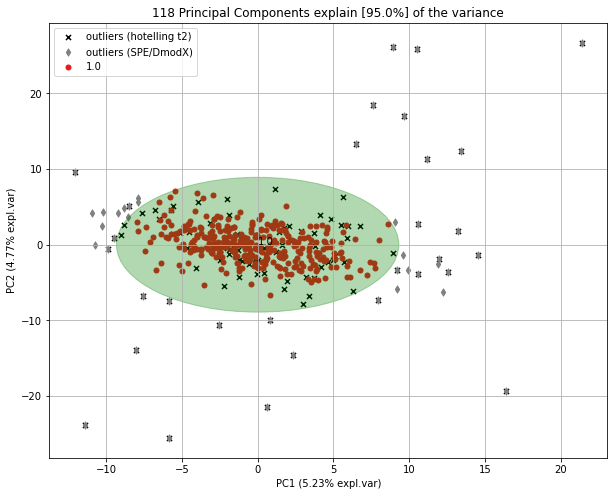

In [457]:
model.scatter(legend=True, SPE=True, hotellingt2=True)

In [458]:
Xoutliers = X[out['outliers']['y_bool'],:]
X_no_outliers = X[~out['outliers']['y_bool'],:]
y_no_outliers = y[~out['outliers']['y_bool'],:]

In [459]:
pd.DataFrame(X_no_outliers)

,0,1,2,3,4,5,6,7,8,9,...,404,405,406,407,408,409,410,411,412,413
0,0.646304,0.902505,0.111318,-0.462552,-0.516473,0.419100,1.030343,-0.592237,-1.977695,-0.184792,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
1,0.646304,-1.108027,1.072799,1.379469,0.719074,1.043144,0.378664,0.250339,2.052442,-0.118426,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
2,1.886547,-1.108027,2.515021,1.379469,-0.061272,0.575111,-0.241983,0.194167,0.502389,-1.091790,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
3,-1.834181,-1.108027,0.495911,-0.462552,0.719074,0.263089,-1.452245,0.109909,0.037373,1.629205,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
4,-0.593938,0.902505,-0.369422,-0.462552,-0.776589,-0.583828,0.285567,-1.041611,-0.505145,0.965548,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,-1.834181,0.902505,-0.657867,-0.462552,-0.516473,-0.093508,-0.148886,-0.114778,-0.388891,0.213403,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
350,0.646304,0.902505,-0.369422,-0.462552,-0.581502,0.976282,0.440728,-0.451808,1.044908,-1.556350,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
351,-0.593938,-1.108027,2.515021,1.379469,0.719074,-0.405530,-0.210951,0.868228,-0.660150,1.164645,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193
352,-0.593938,0.902505,-0.850163,-0.462552,0.263872,-1.096436,0.564858,1.345687,-1.047663,0.456744,...,0.172477,-0.066815,-0.081923,-0.066815,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193,-0.047193


For reduction of the dimension of our data set, we decide to take first 150 PCA components.

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [414] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[150]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


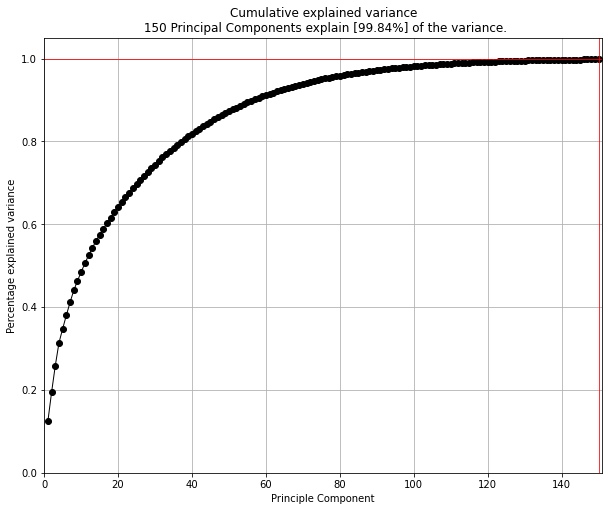

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 150 Principal Components explain [99.84%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [460]:
model = pca(n_components=150)
out = model.fit_transform(X_no_outliers)
model.plot()

In [461]:
X_after_pca = np.array(model.transform(X))

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.


---------
### Classification 

Finally, we will compare four different and well-known algorithms to perform the classification on our data.

In [475]:
X = X_after_pca
y = df.iloc[:, df.columns == 'diagnosis'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  stratify=y)

#### Support Vector Machine

SVMs is machine learning algorithm, often used for classification, regression and outliers detection. SVMs finds the best boundary that separates the data into categories by maximizing the orthogonal distance between the nearest points of each category and the boundary. Talking about linear SVM, in 1D this boundary will be dash, in 2D line, in 3D plane. But SVM offers much more. Especially when it comes to nonlinear classification, which is often the case. The first idea is to see the accuracy for each possible kernel.

linear accuracy:  66.67
poly accuracy:  71.11
rbf accuracy:  65.56
sigmoid accuracy:  71.11
rbf accuracy:  65.56


<AxesSubplot:title={'center':'Accuracy score for different kernels'}>

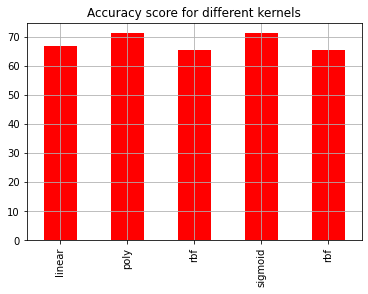

In [476]:
kernel = np.array(['linear', 'poly', 'rbf', 'sigmoid','rbf'])
accuracy_scores = []

for k in kernel:
    svm_ = svm.SVC(kernel=k, degree=1).fit(X_train, y_train)
    y_pred = svm_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(k, 'accuracy: ', "%.2f" % (accuracy*100))
    accuracy_scores.append(accuracy_score(y_test, y_pred)*100)

pd.Series(accuracy_scores,kernel).plot(kind="bar", title="Accuracy score for different kernels", color='red', grid='bool')

From above results, the best candidate is the sigmoid kernel. But just in case, we graphically show the accuracy of the polynomial kernel with degree in range $\langle 0,20 \rangle$.

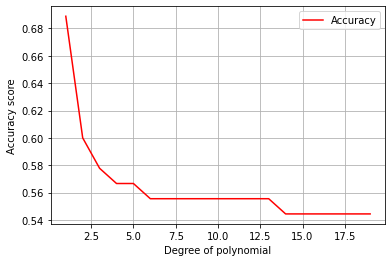

In [464]:
number_degree = [n for n in range(1, 20)]
accuracy_scores = []

for n in number_degree:
    svm_ = svm.SVC(kernel='poly', degree=n).fit(X_train, y_train)
    y_pred = svm_.predict(X_test) 
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(number_degree, accuracy_scores, label="Accuracy", color="red")
ax.set_ylabel("Accuracy score")
ax.set_xlabel("Degree of polynomial")
ax.grid(True)
ax.legend()

#### Logistic Regression Algorithm

Second algoritm we will use is Logistic Regression. Multinomial logistic regression is an extension of Logistic Regression that adds native support for multi-class classification problems. We perform Logistic Regression by modifying the parametar solver - algorithm for the optimization problem. 

newton-cg accuracy:  61.11
lbfgs accuracy:  61.11
sag accuracy:  60.00
saga accuracy:  61.11


<AxesSubplot:title={'center':'Accuracy score for different solver'}>

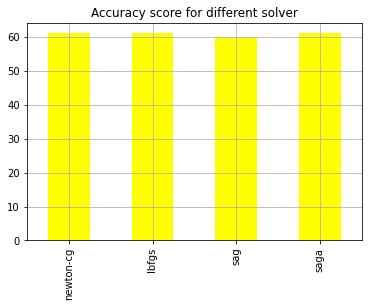

In [465]:
solver = np.array(['newton-cg', 'lbfgs', 'sag', 'saga'])
accuracy_scores = []

for s in solver:
    lm_ = linear_model.LogisticRegression(multi_class='multinomial', solver = s).fit(X_train, y_train)
    y_pred = lm_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(s, 'accuracy: ', "%.2f" % (accuracy*100))
    accuracy_scores.append(accuracy_score(y_test, y_pred)*100)
    
pd.Series(accuracy_scores, solver).plot(kind="bar", title="Accuracy score for different solver", color='yellow', grid='bool')

As we see from the above, best option for optimization algorithm is SAGA.

#### K-Nearest Neighbors Algorithm

Moving on, we will use K-nearest neighbors algorithm. This is very simple algorithm, which assumes that similar things are in close proximity of each other. So if one sample it is "near" to another sample, whatever "near" meant, it assumes that they both belong to similar classes. The only question is how many nearest neighbors to take. This question is illustrated by the following code. 

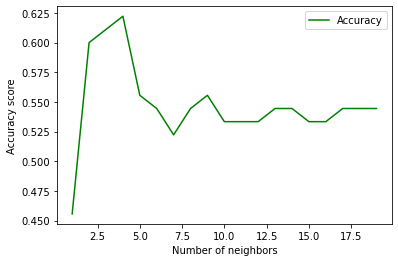

In [466]:
n_neighbors = [n for n in range(1, 20)]
accuracy_scores = []

for n in n_neighbors:
    knn_ = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    y_pred = knn_.predict(X_test) 
    accuracy_scores.append(accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(n_neighbors, accuracy_scores, label="Accuracy", color="green")

ax.set_ylabel("Accuracy score")
ax.set_xlabel("Number of neighbors")
ax.legend()

We see that for biggest accuracy we can take approximately six nearest neighbors.

#### Random Forest Algorithm

And the last classification algorithm we will deal with is Random Forest.

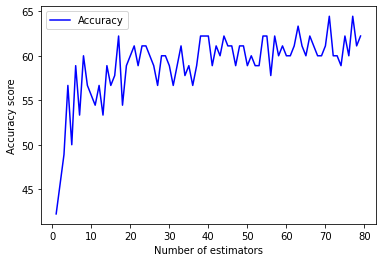

In [467]:
n_estimators = [n for n in range(1, 80)]
accuracy_scores = []

for n in n_estimators:
    ranf = RandomForestClassifier(n_estimators = n).fit(X_train, y_train)
    y_pred = ranf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy*100)
    
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(n_estimators, accuracy_scores, label="Accuracy", color="blue")

ax.set_ylabel("Accuracy score")
ax.set_xlabel("Number of estimators")
ax.legend()

---------
### Conclusion

At the begging, through data survey, we noticed what our medical data were highly undesirable. There were a lot of missing data, parse data, incorrect data, outliers.. However, using certain transformations and methods, we tried to reshape our data to the form that will be useful to the algorithms. After that, by using Principal Component Analysis, we reduced the number of features to 150 preserving almost all variability of our data. Finally, we perform four different clustering algorithms and conclude that Support Vector Machine gives us the highest accuracy.

After data survey, using Principal Component Analysis, we reduced the number of features to 150.